In [20]:
import re
import random
import pandas as pd
import hashlib

In [21]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(.5) for _ in cards_to_age.index]


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [22]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
Powershell,454.137521,90.827504,5
Todd Ideas,804.949778,53.663319,15
PEP 8,1320.618981,165.077373,8
SharePoint,1546.732613,128.894384,12
Debugging in VS Code,1749.175743,87.458787,20
Terraform,1789.395067,71.575803,25
Azure Functions + Visual Studio,1821.121602,130.080114,14
IW Migration,1975.366653,141.097618,14
Open Source/GitHub,2121.068221,132.566764,16
FSLogix,2148.075278,89.503137,24


# Histogram

83072.75


<Axes: >

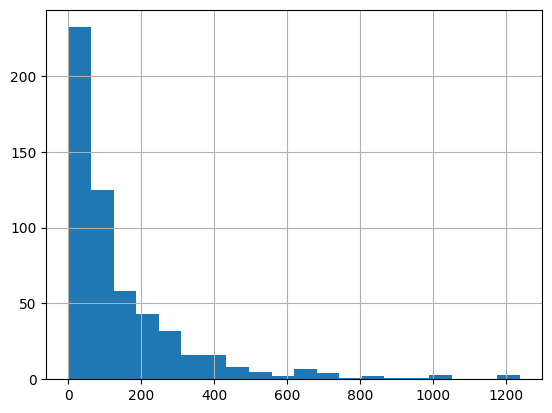

In [23]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [24]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [25]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [26]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [27]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [28]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [29]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [30]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [31]:
# n=10
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [32]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



## Age Max

In [33]:
n = 5
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 559


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
0,Audit Report Tracker (Sharepoint List),Power Automate (Flow) Owner\nDefinition: A use...,8d5e063ee69a83e11e260335f0b685e8,-1236.104827,229.026032,-1236.104827,3664.416518,0.337037,0,0
1,Audit Report Tracker (Sharepoint List),Permissions Endpoint (for managing list permis...,eda0eb7c1a3a9b0ebba749a597e46d22,-421.145934,229.026032,-1236.104827,3664.416518,0.337037,1,0
2,Audit Report Tracker (Sharepoint List),Site Collection Administrator\nDefinition: A u...,c0359d229e67636a45dddedfe736bc8c,-389.577755,229.026032,-1236.104827,3664.416518,0.337037,2,0
72,Audit Report Tracker (Sharepoint List),View (SharePoint View)\nDefinition: A pre-defi...,c9375efcef5b15bae0f26f4f8d80a3f7,-351.432748,229.026032,-1236.104827,3664.416518,0.337037,3,0
73,Audit Report Tracker (Sharepoint List),List Administrator\nDefinition: A user with pe...,c04d54d96d16dfd514a229d890d7b6b4,-220.272397,229.026032,-1236.104827,3664.416518,0.337037,4,0
3,WSL + Kali Linux,wsl.exe and .bashrc\n.bashrc is a script that ...,fec70ed50be50483db47053b6024bbb4,-1216.240895,262.060874,-1216.240895,5765.339227,0.246167,0,0
4,WSL + Kali Linux,wsl Command\nThe primary command-line interfac...,9b93a39837c69c7db3c9152b97cebefd,-729.684106,262.060874,-1216.240895,5765.339227,0.246167,1,0
5,WSL + Kali Linux,WSL Performance Tuning\nFor better performance...,03fec1baebb903eda82ea95f03fe0716,-714.396546,262.060874,-1216.240895,5765.339227,0.246167,2,0
75,WSL + Kali Linux,wsl Command\nThe primary command-line interfac...,2ff6ec8cc28c0d5a7cf021f5b6848f5d,-400.421242,262.060874,-1216.240895,5765.339227,0.246167,3,0
76,WSL + Kali Linux,Xorg\nThe open-source implementation of the X ...,a9445cafce144bd9f3ea44bda5d2fece,-303.353713,262.060874,-1216.240895,5765.339227,0.246167,4,0


## Card Count

In [34]:
# n=10
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)




## Random

In [35]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [36]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
0,Audit Report Tracker (Sharepoint List),Power Automate (Flow) Owner\nDefinition: A use...,8d5e063ee69a83e11e260335f0b685e8,-1236.104827,229.026032,-1236.104827,3664.416518,0.337037,0,0
1,Audit Report Tracker (Sharepoint List),Permissions Endpoint (for managing list permis...,eda0eb7c1a3a9b0ebba749a597e46d22,-421.145934,229.026032,-1236.104827,3664.416518,0.337037,1,0
2,Audit Report Tracker (Sharepoint List),Site Collection Administrator\nDefinition: A u...,c0359d229e67636a45dddedfe736bc8c,-389.577755,229.026032,-1236.104827,3664.416518,0.337037,2,0
72,Audit Report Tracker (Sharepoint List),View (SharePoint View)\nDefinition: A pre-defi...,c9375efcef5b15bae0f26f4f8d80a3f7,-351.432748,229.026032,-1236.104827,3664.416518,0.337037,3,0
73,Audit Report Tracker (Sharepoint List),List Administrator\nDefinition: A user with pe...,c04d54d96d16dfd514a229d890d7b6b4,-220.272397,229.026032,-1236.104827,3664.416518,0.337037,4,0
3,WSL + Kali Linux,wsl.exe and .bashrc\n.bashrc is a script that ...,fec70ed50be50483db47053b6024bbb4,-1216.240895,262.060874,-1216.240895,5765.339227,0.246167,0,0
4,WSL + Kali Linux,wsl Command\nThe primary command-line interfac...,9b93a39837c69c7db3c9152b97cebefd,-729.684106,262.060874,-1216.240895,5765.339227,0.246167,1,0
5,WSL + Kali Linux,WSL Performance Tuning\nFor better performance...,03fec1baebb903eda82ea95f03fe0716,-714.396546,262.060874,-1216.240895,5765.339227,0.246167,2,0
75,WSL + Kali Linux,wsl Command\nThe primary command-line interfac...,2ff6ec8cc28c0d5a7cf021f5b6848f5d,-400.421242,262.060874,-1216.240895,5765.339227,0.246167,3,0
76,WSL + Kali Linux,Xorg\nThe open-source implementation of the X ...,a9445cafce144bd9f3ea44bda5d2fece,-303.353713,262.060874,-1216.240895,5765.339227,0.246167,4,0


In [37]:
existing_cards['age'].mean()

-148.60957284503107